# 0. About

This notebook is to see how the components number, i.e. `n_components`, would affect the linear regression performance.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import warnings

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import CCA, PLSCanonical
from sklearn.utils import Bunch

rs_num = 14
rng = np.random.default_rng(rs_num)

sklearn.set_config(display="diagram")

%matplotlib inline

# 1. Dataset Construction

In [2]:
sample_num = 350
X_dimension_num = 5
Y_dimension_num = 4

# construct X
X = rng.normal(loc=0.0, scale=1.0, size=(sample_num, X_dimension_num))

# construct noise
xi_1 = rng.normal(loc=0, scale=np.sqrt(0.2), size=(sample_num, ))
xi_2 = rng.normal(loc=0, scale=np.sqrt(0.4), size=(sample_num, ))
xi_3 = rng.normal(loc=0, scale=np.sqrt(0.3), size=(sample_num, ))
xi_4 = rng.normal(loc=0, scale=np.sqrt(0.1), size=(sample_num, ))

# construct Y
Y = np.zeros((sample_num, Y_dimension_num))
Y[:, 0] = X[:, 2] + xi_1
Y[:, 1] = X[:, 0] + xi_2
Y[:, 2] = -X[:, 3] + xi_3
Y[:, 3] = -X[:, 1] - xi_4

In [3]:
# some numbers for validation
n_splits = 5
n_repeats = 5

In [4]:
# split dataset into training and testing
[X_train, X_test, Y_train, Y_test] = train_test_split(
    X, Y, test_size=0.20, random_state=rs_num
)

# 2. Baseline

For this one, we just apply standardization, and trian with the linear regression.

In [5]:
baseline_bunch = Bunch()
baseline_bunch.name = 'baseline'

baseline_bunch.pipeline = Pipeline(
    [
        ('scaler', StandardScaler()), 
        ('lr', LinearRegression())
    ]
)

baseline_bunch.cv_scores = cross_validate(
    baseline_bunch.pipeline, X_train, Y_train, 
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=rs_num)
)['test_score']

# also train on the whole training dataset, and see the score on the test dataset
baseline_bunch.pipeline.fit(X_train, Y_train)

# modal evaluation on the test dataset
baseline_bunch.eval_score = baseline_bunch.pipeline.score(X_test, Y_test)

# 3. CCA with different `n_components`

In [6]:
# create a customized cross-validation method
def custom_cv(validator, X, Y, fit_n_score_func, *args):
    # note: normally X and Y are already training datasets
    
    # construct score array
    score_arr = np.zeros((validator.get_n_splits(), ))
    
    # fit and validate
    ii = 0
    for train_ind, test_ind in validator.split(X):
        # slicing arrays
        X_train, X_test = X[train_ind], X[test_ind]
        Y_train, Y_test = Y[train_ind], Y[test_ind]
        
        # train the model and get the score
        score_arr[ii] = fit_n_score_func(X_train, X_test, Y_train, Y_test, *args)
        ii += 1
    
    return score_arr

In [7]:
# create a customized pipeline
def sklearn_cca_fit_n_score(X_train, X_test, Y_train, Y_test, n_components, max_iter, tol):
    # fitting the model
    cca = CCA(n_components=n_components, max_iter=max_iter, tol=tol).fit(X_train, Y_train)
    
    # transform the model
    Xc_train, Yc_train = cca.transform(X_train, Y_train)
    Xc_test, Yc_test = cca.transform(X_test, Y_test)
    
    # train with linear regression and get a score
    return LinearRegression().fit(Xc_train, Yc_train).score(Xc_test, Yc_test)

In [8]:
# some constants for cca
max_iter = int(1e12)
tol = 1e-12

n_components_arr = np.arange(1, np.min([X_dimension_num, Y_dimension_num])+1)
cca_bunch_list = [None] * n_components_arr.size

for i, n_components in enumerate(n_components_arr):
    cca_bunch_list[i] = Bunch()
    cca_bunch_list[i].name = 'n={}'.format(n_components)
    
    rkf = RepeatedKFold(
        n_splits=n_splits, n_repeats=n_repeats, random_state=rs_num
    )
    
    # cross-validation
    cca_bunch_list[i].cv_scores = custom_cv(
        rkf, X_train, Y_train, 
        sklearn_cca_fit_n_score, 
        n_components, max_iter, tol
    )
    
    # evaluate on test datasets
    cca_bunch_list[i].eval_score = sklearn_cca_fit_n_score(
        X_train, X_test, Y_train, Y_test, 
        n_components, max_iter, tol
    )

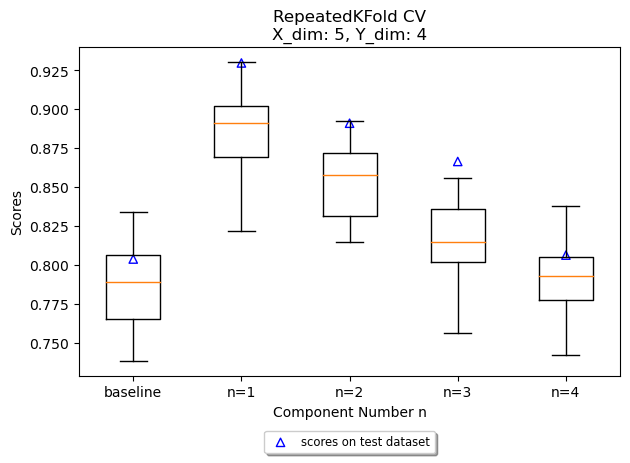

In [9]:
# put everything in one list
bunch_list_all = [baseline_bunch] + cca_bunch_list

# visualize model evaluation
viz_labels = []
viz_boxplots = []
viz_eval_scores = []
viz_eval_scores_pos = []

for i, bunch in enumerate(bunch_list_all):
    viz_labels.append(bunch.name)
    viz_boxplots.append(bunch.cv_scores)
    viz_eval_scores.append(bunch.eval_score)
    viz_eval_scores_pos.append(i+1)

# visualization
fig, ax = plt.subplots()

ax.boxplot(
    viz_boxplots, 
    labels=viz_labels
)
ax.scatter(
    viz_eval_scores_pos, 
    viz_eval_scores,  
    fc='none',
    ec='blue', 
    marker='^', 
    label='scores on test dataset'
)

ax.set(
    xlabel='Component Number n', ylabel='Scores', 
    title='RepeatedKFold CV\n'+'X_dim: {}, Y_dim: {}'.format(
        X_dimension_num, Y_dimension_num
    )
)
ax.set_xticklabels(viz_labels, rotation=0)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True,
    shadow=True,
    ncol=2,
    fontsize='small'
)

plt.tight_layout()